#Set Up

##Data Description:

Employee Compensation


Metadata Updated: June 4, 2019 

---

The San Francisco Controller's Office maintains a database of the salary and benefits paid to City employees since fiscal year 2013. This data is summarized and presented on the Employee Compensation report hosted at http://openbook.sfgov.org, and is also available in this dataset in CSV format. New data is added on a bi-annual basis when available for each fiscal and calendar year. 


---


The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year.

**Dataset contains 832,883 rows, each row is an employee.**

Original data from [data.gov link](https://catalog.data.gov/dataset/employee-compensation-53987)

##Analysis Purpose:

My goal is to review Nursing jobs salary and overtime over the 6 year period (from 2013 to 2018) in order to determine if there is an increase in mean salary earned, as well if there is an increase in overtime earned. I specifically want to test and determine if the increase in overtime is greater then increase in salary, as this would show growing need for nursing staff and could have greater impact on future hiring, budget planning and quality of service provided in this demanding field.


In [0]:
#connect to the data source, in this case a csv file stored on my G Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#required libraries for analysis

!pip install seaborn==0.9.0
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
sns.set()

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
#upload the csv file into pandas

sf_df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/Employee_Compensation.csv')
sf_df.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
0,Calendar,2028,1,Public Protection,CRT,NaN,792.0,Utd Pub EmpL790 SEIU-Crt Clrks,0000,Untitled,420C,Deputy Court Clerk II,8540990,674.28,0.00,5.76,680.04,130.91,0.00,53.86,184.77,864.81
1,Calendar,2028,7,General City Responsibilities,229259,NaN,792.0,Utd Pub EmpL790 SEIU-Crt Clrks,0000,Untitled,420C,Deputy Court Clerk II,8540990,674.28,0.00,5.76,680.04,130.91,0.00,53.86,184.77,864.81
2,Fiscal,2028,1,Public Protection,CRT,NaN,792.0,Utd Pub EmpL790 SEIU-Crt Clrks,0000,Untitled,420C,Deputy Court Clerk II,8540990,674.28,0.00,5.76,680.04,130.91,0.00,53.86,184.77,864.81
3,Calendar,2019,7,General City Responsibilities,229264,NaN,790.0,"SEIU, Local 1021, Misc",8100,Legal & Court,8158,Child Support Officer II,8531303,71806.61,0.00,0.00,71806.61,13726.86,11935.80,5698.69,44038.91,115845.52
4,Calendar,2019,1,Public Protection,POL,NaN,911.0,POA,Q000,Police Services,Q004,Police Officer 3,8493992,114717.00,82272.24,5438.11,202427.35,21230.56,11787.68,3400.44,50657.40,253084.75


#Exploratory Analysis

In [0]:
#what columns are we working with?

sf_df.columns

Index(['Year Type', 'Year', 'Organization Group Code', 'Organization Group',
       'Department Code', 'Department', 'Union Code', 'Union',
       'Job Family Code', 'Job Family', 'Job Code', 'Job',
       'Employee Identifier', 'Salaries', 'Overtime', 'Other Salaries',
       'Total Salary', 'Retirement', 'Health and Dental', 'Other Benefits',
       'Total Benefits', 'Total Compensation'],
      dtype='object')

In [0]:
#let's see overall shape and type of data

sf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832883 entries, 0 to 832882
Data columns (total 22 columns):
Year Type                  832883 non-null object
Year                       832883 non-null int64
Organization Group Code    832883 non-null int64
Organization Group         832883 non-null object
Department Code            803939 non-null object
Department                 423237 non-null object
Union Code                 832369 non-null float64
Union                      832369 non-null object
Job Family Code            832883 non-null object
Job Family                 832883 non-null object
Job Code                   832883 non-null object
Job                        832880 non-null object
Employee Identifier        832883 non-null int64
Salaries                   832883 non-null float64
Overtime                   832883 non-null float64
Other Salaries             832883 non-null float64
Total Salary               832883 non-null float64
Retirement                 832883 non

In [0]:
#let's identify rows that contain nulls
null_rows = sf_df[sf_df.isnull().any(axis=1)]
null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410160 entries, 0 to 580673
Data columns (total 22 columns):
Year Type                  410160 non-null object
Year                       410160 non-null int64
Organization Group Code    410160 non-null int64
Organization Group         410160 non-null object
Department Code            381216 non-null object
Department                 514 non-null object
Union Code                 409646 non-null float64
Union                      409646 non-null object
Job Family Code            410160 non-null object
Job Family                 410160 non-null object
Job Code                   410160 non-null object
Job                        410157 non-null object
Employee Identifier        410160 non-null int64
Salaries                   410160 non-null float64
Overtime                   410160 non-null float64
Other Salaries             410160 non-null float64
Total Salary               410160 non-null float64
Retirement                 410160 non-nu

Looks like the majority of our null values are located in the Department column as well as some in Department Code, the rest are in Union/Union Code, which makes sense if an employee is not part of a union, and looks like we have at least three nulls in the Job category as well.

In [0]:
#what years do we have represented?
sf_df['Year'].unique()

array([2028, 2019, 2018, 2017, 2016, 2015, 2014, 2013])

Looks like we have some rows entered as year 2028, could be an error but I have no way of checking or verifying if it's meant to be 2028 or 2018,  this does not appear to be affecting any rows in the nursing jobs family that I will be conducting analysis on. 

Dataset covers seven years from 2013 to 2019 and since we are currently in the year 2019, I am primarily interested in data from 2013 to 2018.

In [0]:
#what year types do we have represented?
sf_df['Year Type'].unique()

array(['Calendar', 'Fiscal'], dtype=object)

Additionally we have two year types, calendar that runs from January through December and Fiscal that starts on July 1st and ends June 30th of the following year.

In [0]:
#counts of each year type?
sf_df['Year Type'].value_counts().head()

Calendar    498067
Fiscal      334816
Name: Year Type, dtype: int64

Looks like we have more counts of the Calendar year type then Fiscal, but for the purposes of my analysis I will focus on the Fiscal year values going forward.

In [0]:
#how many unique jobs are in the Job Family?

sf_df['Job Family'].unique()

array(['Untitled', 'Legal & Court', 'Police Services', 'Journeyman Trade',
       'Professional Engineering', 'Community Development',
       'Sub-Professional Engineering', 'Housekeeping & Laundry',
       'Protection & Apprehension', 'Semi-Skilled & General Labor',
       'Information Systems', 'Street Transit', 'Human Services',
       'Nursing', 'Library', 'Construction Inspection', 'Fire Services',
       'Med Therapy & Auxiliary', 'Public Service Aide',
       'Budget, Admn & Stats Analysis', 'Clerical, Secretarial & Steno',
       'Correction & Detention', 'Lab, Pharmacy & Med Techs',
       'Agriculture & Horticulture', 'Recreation',
       'Supervisory-Labor & Trade', 'Payroll, Billing & Accounting',
       'Public Health', 'Hospital Administration',
       'Museum & Cultural Affairs', 'Health & Sanitation Inspection',
       'Public Safety Inspection', 'Personnel', 'Dietary & Food',
       'Management', 'Pub Relations & Spec Assts', 'Airport Operation',
       'Skilled Labor'

In [0]:
#counts of each job category

sf_df['Job Family'].value_counts().head(10)

Nursing                          82668
Street Transit                   70084
Police Services                  52582
Journeyman Trade                 49505
Human Services                   43568
Public Service Aide              35535
Clerical, Secretarial & Steno    35291
Fire Services                    33920
Housekeeping & Laundry           26634
Budget, Admn & Stats Analysis    26197
Name: Job Family, dtype: int64

Nursing Job Family is the largest of the data set and will be the focus of my analysis as I am particularly interested in the healthcare sector.

In [0]:
#nursing is the largest group under Job Family
#let's try to isolate the data from this column, fiscal year only

bools = (sf_df['Job Family'] == 'Nursing') & (sf_df['Year Type'] == 'Fiscal')
nursing_df = sf_df.iloc[bools.values]
nursing_df.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
84251,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8513296,13160.52,609.49,1363.12,15133.13,0.00,0.00,868.88,868.88,16002.01
84284,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8602399,65658.44,0.00,1163.50,66821.94,61.51,0.00,4955.05,5016.56,71838.50
84300,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2328,Nurse Practitioner,8565973,89736.51,0.00,250.00,89986.51,16714.77,5861.52,7309.85,29886.14,119872.65
84308,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8530907,135115.04,901.16,2556.12,138572.32,25581.64,13308.78,9563.07,48453.49,187025.81
84313,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8510110,100759.50,6501.79,14131.75,121393.04,21352.98,11802.02,9754.12,42909.12,164302.16


In [0]:
#what do we know about the nursing data?
nursing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32898 entries, 84251 to 832878
Data columns (total 22 columns):
Year Type                  32898 non-null object
Year                       32898 non-null int64
Organization Group Code    32898 non-null int64
Organization Group         32898 non-null object
Department Code            30992 non-null object
Department                 21856 non-null object
Union Code                 32898 non-null float64
Union                      32898 non-null object
Job Family Code            32898 non-null object
Job Family                 32898 non-null object
Job Code                   32898 non-null object
Job                        32898 non-null object
Employee Identifier        32898 non-null int64
Salaries                   32898 non-null float64
Overtime                   32898 non-null float64
Other Salaries             32898 non-null float64
Total Salary               32898 non-null float64
Retirement                 32898 non-null float64
H

We have 32,898 rows of data with some null values in the Department Code and Department categories.

In [0]:
#what different types of jobs are under nursing job family?
nursing_df['Job'].unique()

array(['Special Nurse', 'Nurse Practitioner', 'Registered Nurse',
       'Patient Care Assistant', 'Nurse Manager', 'Nursing Assistant',
       'Licensed Vocational Nurse', 'Sr Cent Proc & Dist Tech',
       'Behavioral Health Team Leader', 'Anesthetist',
       'Psychiatric Technician', 'Surgical Procedures Technician',
       'Clinical Nurse Specialist', 'Nursing Supervisor',
       'Sterile Processing & Dist Tech', 'Nursing Supervisor Psychiatric',
       'Nurse Midwife', 'Central Processing & Dist Tech',
       'Public Health Team Leader', 'Senior Psychiatric Orderly',
       'Operating Room Nurse'], dtype=object)

In [0]:
#counts of each jobs under nursing job category, let's see top five results

nursing_df['Job'].value_counts().head()

Special Nurse                11251
Registered Nurse             10254
Patient Care Assistant        4572
Licensed Vocational Nurse     1745
Nurse Practitioner            1690
Name: Job, dtype: int64

In [0]:
#let's see how many unique employee identifiers are listed in the nursing data set

nursing_df['Employee Identifier'].nunique()

11099

In [0]:
#looks like there are employees listed multiple times, which makes sense as we cover 2013-2019 timeframe

nursing_df['Employee Identifier'].value_counts().head(10)

9525     7
24332    7
34484    7
13058    7
40722    7
9351     7
2769     7
16104    6
3426     6
15986    6
Name: Employee Identifier, dtype: int64

In [0]:
#let's separate nursing jobs by year, since we will have same employee records across multiple years

y2013 = (nursing_df['Year'] == 2013 ) & (nursing_df['Year Type'] == 'Fiscal')
y2013_df = nursing_df.iloc[y2013.values]
y2013_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4328 entries, 793410 to 832878
Data columns (total 22 columns):
Year Type                  4328 non-null object
Year                       4328 non-null int64
Organization Group Code    4328 non-null int64
Organization Group         4328 non-null object
Department Code            4328 non-null object
Department                 4328 non-null object
Union Code                 4328 non-null float64
Union                      4328 non-null object
Job Family Code            4328 non-null object
Job Family                 4328 non-null object
Job Code                   4328 non-null object
Job                        4328 non-null object
Employee Identifier        4328 non-null int64
Salaries                   4328 non-null float64
Overtime                   4328 non-null float64
Other Salaries             4328 non-null float64
Total Salary               4328 non-null float64
Retirement                 4328 non-null float64
Health and Dental  

In [0]:
#I want to know how many unique employee identifiers are present in year 2013
y2013_df['Employee Identifier'].nunique()

4281

In [0]:
#looks like some employees are listed twice, but it's small portion of the total
y2013_df['Employee Identifier'].value_counts().head(50)

12760    2
44753    2
11549    2
9935     2
54968    2
23246    2
44230    2
23279    2
42739    2
6320     2
48033    2
14126    2
19233    2
9351     2
40722    2
25701    2
28476    2
37709    2
4971     2
2938     2
28361    2
44699    2
13722    2
32188    2
41460    2
22984    2
54689    2
9706     2
17830    2
21915    2
54670    2
23485    2
34370    2
11459    2
28238    2
53603    2
53517    2
24036    2
24332    2
8095     2
8911     2
18443    2
20466    2
25593    2
48147    2
28680    2
53294    2
13535    1
14966    1
17017    1
Name: Employee Identifier, dtype: int64

##Data Wrangling

Since we don't know why a particular employee is listed twice (they were assigned to a different department, promoted to a new role, etc.) and the number of those listed twice is less than 5% of the total employee entries in the 2013 subset of records, I will isolate and drop rows that appear multiple times with the same employee identifier. This should eliminate any skew in data as a result of duplicate and/or incomplete salary information for the purpose of this analysis.

In [0]:
#I will drop rows based on the duplicate employee identifier
y2013_single_row_df = y2013_df.drop_duplicates(subset=['Employee Identifier'], keep=False)

#let's review our 2013 data and confirm each employee ID is present only once
y2013_single_row_df['Employee Identifier'].value_counts().head()


35545    1
27268    1
8861     1
27288    1
17045    1
Name: Employee Identifier, dtype: int64

In [0]:
#what's the sape of our resulting data for 2013, where each row is now one unique employee
y2013_single_row_df.shape

(4234, 22)

In [0]:
y2013_single_row_df['Job'].value_counts().head()

Special Nurse                1498
Registered Nurse             1252
Patient Care Assistant        615
Licensed Vocational Nurse     241
Nurse Practitioner            224
Name: Job, dtype: int64

In [0]:
#Let's sort our rows by salary to see what our transformed data set looks like
y2013_sorted_df = y2013_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2013_sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
820989,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,32559,-1861.5,0.0,-62.04,-1923.54,0.00,0.00,-32.69,-32.69,-1956.23
806201,Fiscal,2013,7,General City Responsibilities,UNA,GEN General City / Unallocated,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,25180,0.0,0.0,598.82,598.82,0.00,0.00,47.29,47.29,646.11
799989,Fiscal,2013,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2302,Nursing Assistant,31626,0.0,0.0,551.35,551.35,0.00,0.00,42.17,42.17,593.52
819336,Fiscal,2013,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2312,Licensed Vocational Nurse,42087,0.0,0.0,85.35,85.35,0.00,0.00,6.53,6.53,91.88
831702,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,53037,0.0,0.0,0.00,0.00,0.00,0.00,500.85,500.85,500.85
816742,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,8558,0.0,0.0,22942.85,22942.85,0.00,0.00,1755.13,1755.13,24697.98
816617,Fiscal,2013,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2303,Patient Care Assistant,46167,0.0,0.0,250.00,250.00,0.00,261.45,10.23,271.68,521.68
805576,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,25158,0.0,0.0,50.00,50.00,1137.91,0.00,442.08,1579.99,1629.99
830340,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,10328,0.0,0.0,181.13,181.13,0.00,0.00,13.86,13.86,194.99
807923,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,36661,0.0,0.0,5513.76,5513.76,0.00,0.00,421.81,421.81,5935.57


##Observations, Fiscal Year 2013

Looks like in 2013 we have at least one entry with negative salaries and there are employees listed with zero dollars in salaries but who received compensation under "other salaries", which contributes to their total compensation, with some amounts being very small (in hundreds of dollars).

In [0]:
#let's separate nursing jobs for 2014

y2014 = (nursing_df['Year'] == 2014 )
y2014_df = nursing_df.iloc[y2014.values]
y2014_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4267 entries, 712656 to 753502
Data columns (total 22 columns):
Year Type                  4267 non-null object
Year                       4267 non-null int64
Organization Group Code    4267 non-null int64
Organization Group         4267 non-null object
Department Code            4267 non-null object
Department                 4267 non-null object
Union Code                 4267 non-null float64
Union                      4267 non-null object
Job Family Code            4267 non-null object
Job Family                 4267 non-null object
Job Code                   4267 non-null object
Job                        4267 non-null object
Employee Identifier        4267 non-null int64
Salaries                   4267 non-null float64
Overtime                   4267 non-null float64
Other Salaries             4267 non-null float64
Total Salary               4267 non-null float64
Retirement                 4267 non-null float64
Health and Dental  

In [0]:
#let's identify how many unique employees are represented in the year 2014

y2014_df['Employee Identifier'].nunique()

4239

In [0]:
#looks like some employees are listed twice, but it's small portion of the total

y2014_df['Employee Identifier'].value_counts().head(50)

44380    2
9351     2
10709    2
34925    2
22021    2
37084    2
17157    2
48429    2
41693    2
3426     2
27518    2
16617    2
19009    2
38057    2
20685    2
43833    2
39196    2
16226    2
4232     2
39771    2
51089    2
26105    2
34309    2
11160    2
9525     2
32421    2
16104    2
1127     2
23246    1
39654    1
41098    1
17125    1
43748    1
29411    1
10968    1
51936    1
45791    1
45192    1
43740    1
47834    1
14585    1
25297    1
8662     1
6866     1
21207    1
39646    1
35545    1
49901    1
37615    1
2848     1
Name: Employee Identifier, dtype: int64

In [0]:
#we have a few employees listed twice since they represent less than 5% of the 2014 data, we can drop them

y2014_single_row_df = y2014_df.drop_duplicates(subset=['Employee Identifier'], keep=False)
y2014_single_row_df['Employee Identifier'].value_counts().head()

35545    1
31474    1
49901    1
8662     1
39654    1
Name: Employee Identifier, dtype: int64

In [0]:
#what's the sape of our resulting data for 2014, where each row is one employee
y2014_single_row_df.shape

(4211, 22)

In [0]:
y2014_single_row_df['Job'].value_counts().head()

Special Nurse                1439
Registered Nurse             1233
Patient Care Assistant        652
Licensed Vocational Nurse     243
Nurse Practitioner            233
Name: Job, dtype: int64

In [0]:
#Let's sort our rows by salary to see what our transformed data set looks like
y2014_sorted_df = y2014_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2014_sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
741196,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,49308,-5255.50,0.0,69.89,-5185.61,-1212.70,0.00,-25.49,-1238.19,-6423.80
713254,Fiscal,2014,4,Community Health,DPH,DPH Public Health,858.0,"Teamsters - Supervising Nurses, Local 856",2300,Nursing,2326,Nursing Supervisor Psychiatric,51226,-3962.26,0.0,23315.62,19353.36,-771.82,-193.95,1267.29,301.52,19654.88
745452,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,8878,-3165.00,0.0,18229.72,15064.72,-780.37,-287.64,398.19,-669.82,14394.90
732697,Fiscal,2014,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2302,Nursing Assistant,56396,-1266.50,0.0,8178.73,6912.23,-232.81,-239.71,526.02,53.50,6965.73
723154,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,30006,-604.90,0.0,0.00,-604.90,-122.25,0.00,-47.81,-170.06,-774.96
735475,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,29531,-598.69,0.0,8.24,-590.45,498.30,0.00,149.20,647.50,57.05
738066,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,32547,0.00,0.0,5613.12,5613.12,0.00,-193.95,433.02,239.07,5852.19
751465,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,16146,0.00,0.0,1226.75,1226.75,0.00,0.00,93.85,93.85,1320.60
746064,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,26165,0.00,0.0,14287.63,14287.63,0.00,0.00,1093.00,1093.00,15380.63
724857,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,37681,0.00,0.0,234.08,234.08,0.00,0.00,17.90,17.90,251.98


##Observations, Fiscal Year 2014

Looks like once again we have some negative values listed for salaries and some zeros as well, this is something to keep in mind as we continue the analysis. Without additional information it's hard to determine why some employees have negative value listed, and for as long as they comprise less than 5% of the population, we can omit their numbers during statistical analysis.

In [0]:
#let's separate nursing jobs for 2015

y2015 = (nursing_df['Year'] == 2015 )
y2015_df = nursing_df.iloc[y2015.values]
y2015_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4381 entries, 628139 to 671200
Data columns (total 22 columns):
Year Type                  4381 non-null object
Year                       4381 non-null int64
Organization Group Code    4381 non-null int64
Organization Group         4381 non-null object
Department Code            4381 non-null object
Department                 4381 non-null object
Union Code                 4381 non-null float64
Union                      4381 non-null object
Job Family Code            4381 non-null object
Job Family                 4381 non-null object
Job Code                   4381 non-null object
Job                        4381 non-null object
Employee Identifier        4381 non-null int64
Salaries                   4381 non-null float64
Overtime                   4381 non-null float64
Other Salaries             4381 non-null float64
Total Salary               4381 non-null float64
Retirement                 4381 non-null float64
Health and Dental  

In [0]:
# let's see how many unique employees are represented in year 2015 data set
y2015_df['Employee Identifier'].nunique()

4341

In [0]:
#looks like some employees are listed twice, but it's small portion of the total
y2015_df['Employee Identifier'].value_counts().head(50)

51352    2
29737    2
11173    2
35728    2
23457    2
38434    2
36939    2
34484    2
44581    2
39996    2
18233    2
21903    2
38294    2
24332    2
43976    2
21616    2
50742    2
13058    2
31070    2
34620    2
47424    2
24221    2
19089    2
40032    2
15960    2
4287     2
50596    2
40995    2
13649    2
38395    2
35545    2
19426    2
15871    2
54233    2
32474    2
14942    2
2769     2
32497    2
6678     2
16373    2
51880    1
15006    1
42586    1
37543    1
677      1
43692    1
7283     1
2720     1
40198    1
41654    1
Name: Employee Identifier, dtype: int64

In [0]:
# as expected from previous years, we have some emplyoees listed twice in the year 2015
# since there are less then 5% of them, let's drop those rows and check our results

y2015_single_row_df = y2015_df.drop_duplicates(subset=['Employee Identifier'], keep=False)
y2015_single_row_df['Employee Identifier'].value_counts().head()

22525    1
41654    1
39606    1
53939    1
31410    1
Name: Employee Identifier, dtype: int64

In [0]:
#what's the sape of our resulting data for 2015, where each row is one employee
y2015_single_row_df.shape

(4301, 22)

In [0]:
y2015_single_row_df['Job'].value_counts().head()

Special Nurse                1512
Registered Nurse             1327
Patient Care Assistant        610
Nurse Practitioner            241
Licensed Vocational Nurse     211
Name: Job, dtype: int64

In [0]:
#let's sort our rows by salary to see what our transformed data set looks like
y2015_sorted_df = y2015_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2015_sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
660945,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,16535,-2716.50,0.0,10250.72,7534.22,-633.49,-239.48,573.86,-299.11,7235.11
649253,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,24477,-1696.80,0.0,0.00,-1696.80,231.33,-143.74,-284.61,-197.02,-1893.82
637470,Fiscal,2015,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2302,Nursing Assistant,19602,-318.45,0.0,9651.00,9332.55,-89.69,0.00,712.94,623.25,9955.80
663101,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,34632,0.00,0.0,0.00,0.00,0.00,0.00,84.17,84.17,84.17
658755,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,15819,0.00,0.0,1029.28,1029.28,0.00,0.00,78.74,78.74,1108.02
663448,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2325,Nurse Midwife,1874,0.00,0.0,0.00,0.00,0.00,12.86,0.00,12.86,12.86
656918,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,46663,0.00,0.0,2231.24,2231.24,0.00,0.00,170.69,170.69,2401.93
656867,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,47428,0.00,0.0,27825.11,27825.11,0.00,0.00,2128.62,2128.62,29953.73
628840,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,43830,0.00,0.0,21763.91,21763.91,0.00,12.86,1518.11,1530.97,23294.88
646508,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,39896,0.00,0.0,6791.22,6791.22,0.00,12.86,519.52,532.38,7323.60


##Observations, Fiscal Year 2015

Similar to the previous years we have at least 3 rows with negative values for salaries and multiple rows with zero value under salaries, in some cases with dollar amounts in "other salaries" category.

In [0]:
#let's separate nursing jobs in 2016

y2016 = (nursing_df['Year'] == 2016 )
y2016_df = nursing_df.iloc[y2016.values]
y2016_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4347 entries, 541059 to 585138
Data columns (total 22 columns):
Year Type                  4347 non-null object
Year                       4347 non-null int64
Organization Group Code    4347 non-null int64
Organization Group         4347 non-null object
Department Code            4347 non-null object
Department                 4347 non-null object
Union Code                 4347 non-null float64
Union                      4347 non-null object
Job Family Code            4347 non-null object
Job Family                 4347 non-null object
Job Code                   4347 non-null object
Job                        4347 non-null object
Employee Identifier        4347 non-null int64
Salaries                   4347 non-null float64
Overtime                   4347 non-null float64
Other Salaries             4347 non-null float64
Total Salary               4347 non-null float64
Retirement                 4347 non-null float64
Health and Dental  

In [0]:
#let's identify number of unique employees in 2016 data
y2016_df['Employee Identifier'].nunique()

4292

In [0]:
#looks like some employees are listed twice, but it's small portion of the total
y2016_df['Employee Identifier'].value_counts().head(60)

30059    2
3906     2
1555     2
41822    2
43334    2
55020    2
6547     2
31802    2
7553     2
6298     2
20923    2
11159    2
49527    2
33198    2
45174    2
55927    2
31841    2
21946    2
25631    2
34940    2
24979    2
5792     2
14170    2
19531    2
36472    2
13058    2
42833    2
37623    2
9930     2
20481    2
36088    2
41718    2
45384    2
1848     2
7929     2
20818    2
44666    2
7945     2
9525     2
40722    2
14500    2
32435    2
45213    2
41181    2
34484    2
22199    2
43509    2
1562     2
53223    2
21493    2
32678    2
23043    2
49137    2
10980    2
18982    2
55866    1
49717    1
6690     1
49865    1
33345    1
Name: Employee Identifier, dtype: int64

In [0]:
#as there are less than 5% of employees listed twice, we will identify and drop those rows

y2016_single_row_df = y2016_df.drop_duplicates(subset=['Employee Identifier'], keep=False)
y2016_single_row_df['Employee Identifier'].value_counts().head()

35545    1
31426    1
39646    1
41693    1
43740    1
Name: Employee Identifier, dtype: int64

In [0]:
#what's the sape of our resulting data for 2016, where each row is one employee
y2016_single_row_df.shape

(4237, 22)

In [0]:
y2016_single_row_df['Job'].value_counts().head()

Special Nurse                1549
Registered Nurse             1309
Patient Care Assistant        549
Nurse Practitioner            225
Licensed Vocational Nurse     219
Name: Job, dtype: int64

In [0]:
#Let's sort our rows by salary to see what our transformed data set looks like
y2016_sorted_df = y2016_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2016_sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
570005,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,35851,-4623.74,0.0,6078.53,1454.79,0.00,-333.56,-908.18,-1241.74,213.05
582027,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,17265,-1214.85,0.0,413.92,-800.93,-266.54,0.00,-64.56,-331.10,-1132.03
562711,Fiscal,2016,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2302,Nursing Assistant,4845,0.00,0.0,5827.71,5827.71,0.00,0.00,445.82,445.82,6273.53
560018,Fiscal,2016,4,Community Health,DPH,DPH Public Health,858.0,"Teamsters - Supervising Nurses, Local 856",2300,Nursing,2326,Nursing Supervisor Psychiatric,41522,0.00,0.0,35394.87,35394.87,0.00,0.00,513.23,513.23,35908.10
581673,Fiscal,2016,4,Community Health,DPH,DPH Public Health,858.0,"Teamsters - Supervising Nurses, Local 856",2300,Nursing,2324,Nursing Supervisor,43501,0.00,0.0,2122.58,2122.58,0.00,0.00,56.99,56.99,2179.57
546193,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,46430,0.00,0.0,250.00,250.00,0.00,309.26,30.36,339.62,589.62
578179,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,2720,0.00,0.0,4019.93,4019.93,0.00,0.00,307.52,307.52,4327.45
581709,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,9046,0.00,0.0,19249.81,19249.81,0.00,0.00,1472.60,1472.60,20722.41
576765,Fiscal,2016,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2303,Patient Care Assistant,18480,0.00,0.0,200.00,200.00,0.00,309.26,21.14,330.40,530.40
574598,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,12079,0.00,0.0,6538.72,6538.72,0.00,0.00,500.22,500.22,7038.94


##Observations, Fiscal Year 2016

Similar to the previous years we have at least 2 rows with negative values for salaries and multiple rows with zero value under salaries column, in some cases with dollar amounts in "other salaries" category.

In [0]:
#let's separate nursing jobs for 2017

y2017 = (nursing_df['Year'] == 2017 )
y2017_df = nursing_df.iloc[y2017.values]
y2017_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4533 entries, 450980 to 496655
Data columns (total 22 columns):
Year Type                  4533 non-null object
Year                       4533 non-null int64
Organization Group Code    4533 non-null int64
Organization Group         4533 non-null object
Department Code            4533 non-null object
Department                 4533 non-null object
Union Code                 4533 non-null float64
Union                      4533 non-null object
Job Family Code            4533 non-null object
Job Family                 4533 non-null object
Job Code                   4533 non-null object
Job                        4533 non-null object
Employee Identifier        4533 non-null int64
Salaries                   4533 non-null float64
Overtime                   4533 non-null float64
Other Salaries             4533 non-null float64
Total Salary               4533 non-null float64
Retirement                 4533 non-null float64
Health and Dental  

In [0]:
#let's check number of unique emplyee identifiers present in 2017 data

y2017_df['Employee Identifier'].nunique()

4488

In [0]:
#once again, with less than 5% of those listed appear more than once and can be dropped

y2017_single_row_df = y2017_df.drop_duplicates(subset=['Employee Identifier'], keep=False)
y2017_single_row_df['Employee Identifier'].value_counts().head()

24688    1
8861     1
4751     1
19193    1
21139    1
Name: Employee Identifier, dtype: int64

In [0]:
#what's the shape of our resulting data for 2017, where each row is one employee
y2017_single_row_df.shape

(4443, 22)

In [0]:
y2017_single_row_df['Job'].value_counts().head()

Special Nurse                1644
Registered Nurse             1410
Patient Care Assistant        559
Nurse Practitioner            215
Licensed Vocational Nurse     211
Name: Job, dtype: int64

In [0]:
#Let's sort our rows by salary to see what our transformed data set looks like
y2017_sorted_df = y2017_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2017_sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
474637,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,12944,-1174.78,0.0,-12.59,-1187.37,0.0,-92.30,-92.15,-184.45,-1371.82
492668,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,10791,-242.29,0.0,5342.78,5100.49,0.0,-23.07,389.92,366.85,5467.34
483434,Fiscal,2017,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2302,Nursing Assistant,8837,0.00,0.0,10542.67,10542.67,0.0,0.00,806.51,806.51,11349.18
458369,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,36078,0.00,0.0,16790.73,16790.73,0.0,0.00,243.47,243.47,17034.20
473557,Fiscal,2017,4,Community Health,DPH,DPH Public Health,250.0,"SEIU - Health Workers, Local 1021",2300,Nursing,2302,Nursing Assistant,20818,0.00,0.0,7222.77,7222.77,0.0,0.00,552.54,552.54,7775.31
487618,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,48912,0.00,0.0,12296.09,12296.09,0.0,0.00,940.65,940.65,13236.74
488849,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,40998,0.00,0.0,24645.87,24645.87,0.0,0.00,1506.60,1506.60,26152.47
486367,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,6736,0.00,0.0,86.59,86.59,0.0,0.00,6.63,6.63,93.22
489065,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,28930,0.00,0.0,250.00,250.00,0.0,0.00,0.00,0.00,250.00
470718,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,8643,0.00,0.0,21938.49,21938.49,0.0,0.00,1678.29,1678.29,23616.78


##Observations, Fiscal Year 2017

Similar to the previous years we have at least 1 rows with negative values for salaries and multiple rows with zero value under salaries, in some cases with dollar amounts in "other salaries" category contributing to the dollar amount in "total compensation".

In [0]:
#let's separate nursing jobs for 2018

y2018 = (nursing_df['Year'] == 2018 )
y2018_df = nursing_df.iloc[y2018.values]
y2018_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6434 entries, 223518 to 298145
Data columns (total 22 columns):
Year Type                  6434 non-null object
Year                       6434 non-null int64
Organization Group Code    6434 non-null int64
Organization Group         6434 non-null object
Department Code            4528 non-null object
Department                 0 non-null object
Union Code                 6434 non-null float64
Union                      6434 non-null object
Job Family Code            6434 non-null object
Job Family                 6434 non-null object
Job Code                   6434 non-null object
Job                        6434 non-null object
Employee Identifier        6434 non-null int64
Salaries                   6434 non-null float64
Overtime                   6434 non-null float64
Other Salaries             6434 non-null float64
Total Salary               6434 non-null float64
Retirement                 6434 non-null float64
Health and Dental     

In [0]:
# let's see how many unique employee id numbers are present in the 2018 data

y2018_df['Employee Identifier'].nunique()

4478

##What is Different About Year 2018?
We have a significant increase in number of rows compared to other years, but only 4478 unique employee identifiers, which is pretty consistent with number of nursing employees from previous years. Additionally, it looks like only 4528 employees have a department code listed.

In [0]:
# let's check how many times some of the same employee ids appear in 2018 data

y2018_df['Employee Identifier'].value_counts().head()

8541014    3
8494093    3
8511843    3
8510244    3
8577086    3
Name: Employee Identifier, dtype: int64

In [0]:
#Let's sort our rows by employee identifier, to see if we can determine why same employees are listed up to 3 times in 2018
sorted_df = y2018_df.sort_values(by= 'Employee Identifier', ascending=True)

#select the first 10 rows
sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
275453,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8491294,40850.41,0.00,29625.88,70476.29,0.00,0.00,3615.94,3615.94,74092.23
265595,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8491294,0.00,0.00,284.75,284.75,0.00,0.00,0.00,0.00,284.75
232372,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2312,Licensed Vocational Nurse,8491295,9653.30,0.00,0.00,9653.30,1858.25,2121.39,735.91,4715.55,14368.85
292887,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8492792,85436.57,505.97,6814.79,92757.33,17264.68,8337.42,6885.70,32487.80,125245.13
285203,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8492792,0.00,0.00,25.00,25.00,0.00,0.00,0.00,0.00,25.00
226716,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8492793,492.00,0.00,25.00,517.00,0.00,0.00,0.00,0.00,517.00
259452,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8492793,126360.47,0.00,1614.97,127975.44,23972.24,13746.81,10150.84,47869.89,175845.33
242457,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8492794,117800.00,0.00,250.00,118050.00,22111.00,11114.65,9475.74,42701.39,160751.39
238286,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8492795,16566.91,0.00,0.00,16566.91,0.00,0.00,1285.86,1285.86,17852.77
259433,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8492795,75845.80,0.00,291.07,76136.87,14290.86,8324.95,6028.68,28644.49,104781.36


In [0]:
#let's identify rows that contain nulls in the department code for 2018, possibly showing temporary status staff who were not yet assigned to DPH

y2018_null_rows = y2018_df[y2018_df["Department Code"].isnull()]
y2018_null_rows.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
223518,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8559593,462.50,0.00,25.00,487.50,0.0,0.0,0.0,0.0,487.50
223603,Fiscal,2018,7,General City Responsibilities,NaN,NaN,858.0,"Teamsters, Local 856, Spv RN",2300,Nursing,2322,Nurse Manager,8512237,621.40,0.00,55.89,677.29,0.0,0.0,0.0,0.0,677.29
223644,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8552409,607.50,0.00,15.19,622.69,0.0,0.0,0.0,0.0,622.69
223687,Fiscal,2018,7,General City Responsibilities,NaN,NaN,858.0,"Teamsters, Local 856, Spv RN",2300,Nursing,2322,Nurse Manager,8596795,652.40,0.00,91.34,743.74,0.0,0.0,0.0,0.0,743.74
223696,Fiscal,2018,7,General City Responsibilities,NaN,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2303,Patient Care Assistant,8519064,196.50,276.32,0.00,472.82,0.0,0.0,0.0,0.0,472.82
223697,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8495883,652.30,0.00,65.23,717.53,0.0,0.0,0.0,0.0,717.53
223760,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8540193,1072.20,0.00,178.70,1250.90,0.0,0.0,0.0,0.0,1250.90
223795,Fiscal,2018,7,General City Responsibilities,NaN,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8527723,867.15,0.00,144.53,1011.68,0.0,0.0,0.0,0.0,1011.68
223836,Fiscal,2018,7,General City Responsibilities,NaN,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2302,Nursing Assistant,8510068,286.20,0.00,31.02,317.22,0.0,0.0,0.0,0.0,317.22
223943,Fiscal,2018,7,General City Responsibilities,NaN,NaN,858.0,"Teamsters, Local 856, Spv RN",2300,Nursing,2322,Nurse Manager,8513115,735.60,0.00,139.80,875.40,0.0,0.0,0.0,0.0,875.40


In [0]:
# results look consistent with zero values in retirement and other benefits, and relatively low salaries for temporary hires
# let's see what happens when we drop rows with null values in the department code, leaving only nurses assigned to DPH.

y2018_clean_df = y2018_df.dropna(subset=["Department Code"])
y2018_clean_df.head(5)


,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
223583,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2312,Licensed Vocational Nurse,8518763,76370.60,7400.80,250.00,84021.40,14701.29,13863.98,6702.92,35268.19,119289.59
223584,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8512270,11008.40,1252.68,1670.24,13931.32,0.00,0.00,753.65,753.65,14684.97
223590,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8595918,22270.05,607.37,4325.18,27202.60,0.00,0.00,1652.81,1652.81,28855.41
223611,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8525279,130227.90,5680.19,5548.13,141456.22,25438.25,12272.40,10347.78,48058.43,189514.65
223620,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8595912,41847.70,0.00,6844.25,48691.95,9139.51,0.00,2383.66,11523.17,60215.12


In [0]:
# what does the resulting data look like?

y2018_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528 entries, 223583 to 298145
Data columns (total 22 columns):
Year Type                  4528 non-null object
Year                       4528 non-null int64
Organization Group Code    4528 non-null int64
Organization Group         4528 non-null object
Department Code            4528 non-null object
Department                 0 non-null object
Union Code                 4528 non-null float64
Union                      4528 non-null object
Job Family Code            4528 non-null object
Job Family                 4528 non-null object
Job Code                   4528 non-null object
Job                        4528 non-null object
Employee Identifier        4528 non-null int64
Salaries                   4528 non-null float64
Overtime                   4528 non-null float64
Other Salaries             4528 non-null float64
Total Salary               4528 non-null float64
Retirement                 4528 non-null float64
Health and Dental     

In [0]:
#now let's identify how many unique employee id numbers are present in clean 2018 data

y2018_clean_df['Employee Identifier'].nunique()

4475

In [0]:
#let's see how many times some of the id numbers appear after we dropped ones without assigned department code

y2018_clean_df['Employee Identifier'].value_counts().head()

8494092    2
8596786    2
8541014    2
8492795    2
8578059    2
Name: Employee Identifier, dtype: int64

In [0]:
#with our employees listed twice being less than 5% of the total 2018 data set, we can drop those rows

y2018_single_row_df = y2018_clean_df.drop_duplicates(subset=['Employee Identifier'], keep=False)
y2018_single_row_df['Employee Identifier'].value_counts().head()

8513535    1
8559266    1
8508055    1
8514200    1
8510106    1
Name: Employee Identifier, dtype: int64

In [0]:
#what's the shape of our resulting data for 2018, where each row is one employee

y2018_single_row_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4422 entries, 223583 to 298145
Data columns (total 22 columns):
Year Type                  4422 non-null object
Year                       4422 non-null int64
Organization Group Code    4422 non-null int64
Organization Group         4422 non-null object
Department Code            4422 non-null object
Department                 0 non-null object
Union Code                 4422 non-null float64
Union                      4422 non-null object
Job Family Code            4422 non-null object
Job Family                 4422 non-null object
Job Code                   4422 non-null object
Job                        4422 non-null object
Employee Identifier        4422 non-null int64
Salaries                   4422 non-null float64
Overtime                   4422 non-null float64
Other Salaries             4422 non-null float64
Total Salary               4422 non-null float64
Retirement                 4422 non-null float64
Health and Dental     

In [0]:
y2018_single_row_df['Job'].value_counts().head()

Special Nurse                1636
Registered Nurse             1390
Patient Care Assistant        562
Nurse Practitioner            214
Licensed Vocational Nurse     208
Name: Job, dtype: int64

In [0]:
#Let's sort our resulting rows for year 2018 by salaries
y2018_sorted_df = y2018_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2018_sorted_df.head(50)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
290915,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8604180,0.0,0.00,18856.04,18856.04,0.0,0.00,1397.87,1397.87,20253.91
258910,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8566451,0.0,0.00,2695.34,2695.34,0.0,0.00,206.19,206.19,2901.53
286857,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2303,Patient Care Assistant,8582143,0.0,0.00,230.60,230.60,0.0,0.00,17.64,17.64,248.24
297561,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8591001,0.0,0.00,1223.72,1223.72,0.0,0.00,93.61,93.61,1317.33
243612,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8564459,0.0,0.00,7767.90,7767.90,0.0,0.00,594.24,594.24,8362.14
234088,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2328,Nurse Practitioner,8561428,0.0,0.00,219.36,219.36,0.0,0.00,16.78,16.78,236.14
243556,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8580265,0.0,0.00,122.80,122.80,0.0,0.00,9.52,9.52,132.32
272117,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8564460,0.0,138.04,0.00,138.04,0.0,0.00,10.68,10.68,148.72
275919,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2320,Registered Nurse,8567513,0.0,0.00,4960.11,4960.11,0.0,0.00,379.45,379.45,5339.56
273989,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2302,Nursing Assistant,8585217,0.0,0.00,15479.01,15479.01,0.0,0.00,1184.15,1184.15,16663.16


##Observations, Fiscal Year 2018:

No negative values in the salaries category, but it looks like there are multiple rows with zero under salaries and overtime, and values listed under "other salaries".

In [0]:
#let's separate nursing jobs for 2019

y2019 = (nursing_df['Year'] == 2019 )
y2019_df = nursing_df.iloc[y2019.values]
y2019_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4608 entries, 84251 to 131150
Data columns (total 22 columns):
Year Type                  4608 non-null object
Year                       4608 non-null int64
Organization Group Code    4608 non-null int64
Organization Group         4608 non-null object
Department Code            4608 non-null object
Department                 0 non-null object
Union Code                 4608 non-null float64
Union                      4608 non-null object
Job Family Code            4608 non-null object
Job Family                 4608 non-null object
Job Code                   4608 non-null object
Job                        4608 non-null object
Employee Identifier        4608 non-null int64
Salaries                   4608 non-null float64
Overtime                   4608 non-null float64
Other Salaries             4608 non-null float64
Total Salary               4608 non-null float64
Retirement                 4608 non-null float64
Health and Dental      

In [0]:
#let's check how many unique employee ids are present in 2019 data

y2019_df['Employee Identifier'].nunique()

4565

In [0]:
#less than 5% of the 2019 population is listed more than once, let's drop those rows

y2019_single_row_df = y2019_df.drop_duplicates(subset=['Employee Identifier'], keep=False)
y2019_single_row_df['Employee Identifier'].value_counts().head()

8574050    1
8519436    1
8508255    1
8518278    1
8508039    1
Name: Employee Identifier, dtype: int64

In [0]:
#let's review resulting data set shape

y2019_single_row_df.shape

(4522, 22)

In [0]:
y2019_single_row_df['Job'].value_counts().head()

Special Nurse                1633
Registered Nurse             1453
Patient Care Assistant        548
Licensed Vocational Nurse     228
Nurse Practitioner            214
Name: Job, dtype: int64

In [0]:
#let's sort our rows by salary to see what our transformed data set looks like

y2019_sorted_df = y2019_single_row_df.sort_values(by= 'Salaries', ascending=True)

#select the first 10 rows
y2019_sorted_df.head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
109932,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8542745,-3794.99,0.00,0.00,-3794.99,0.0,0.0,-294.55,-294.55,-4089.54
130094,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8507697,-870.50,0.00,668.65,-201.85,0.0,0.0,9.74,9.74,-192.11
109725,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8494077,-460.98,0.00,0.00,-460.98,0.0,0.0,27.41,27.41,-433.57
97086,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8507690,-368.10,0.00,-73.62,-441.72,0.0,0.0,0.00,0.00,-441.72
102017,Fiscal,2019,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2303,Patient Care Assistant,8578505,0.00,372.87,0.00,372.87,0.0,0.0,29.54,29.54,402.41
118959,Fiscal,2019,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2302,Nursing Assistant,8543231,0.00,94.38,0.00,94.38,0.0,0.0,7.47,7.47,101.85
118985,Fiscal,2019,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2303,Patient Care Assistant,8597437,0.00,112.37,0.00,112.37,0.0,0.0,8.90,8.90,121.27
119033,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8508911,0.00,431.60,0.00,431.60,0.0,0.0,34.19,34.19,465.79
119235,Fiscal,2019,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2302,Nursing Assistant,8544136,0.00,8.74,0.00,8.74,0.0,0.0,0.69,0.69,9.43
102465,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8507712,0.00,18.59,0.00,18.59,0.0,0.0,1.44,1.44,20.03


##Observations, Fiscal Year 2019:

Looks like at least 3 rows with negative values for salaries and once again, multiple rows with zero listed for salaries and overtime. Since our data was last updated on June 4th, and as of the date of this analysis mid June the remaining data for Fiscal Year 2019 is not available, I will include that year's data for comparison knowing that it's incomplete.

#Statistical Analysis  of Nursing Jobs in San Francisco: 
#Overtime and Salary

In [0]:
# our data has the same columns, use concat function to join all the years:

y2013 = y2013_single_row_df
y2014 = y2014_single_row_df
y2015 = y2015_single_row_df
y2016 = y2016_single_row_df
y2017 = y2017_single_row_df
y2018 = y2018_single_row_df
y2019 = y2019_single_row_df

nursing_jobs = pd.concat([y2013, y2014, y2015, y2016, y2017, y2018, y2019])

# it doesn't make sense to have negative value salaries
# and there are only few rows in each year, so I will filter them out

no_zero_nursing = ( nursing_jobs ['Salaries'] > 0)
nursing = nursing_jobs.iloc[no_zero_nursing.values]

# to show the before and after, I will print shape of the data set before 
#and after dropping zero dollar salaries, which is less than 5% of the data

print(nursing_jobs.shape)
print(nursing.shape)

(30370, 22)
(29889, 22)


##Overtime

At this point I am particularly interested in overtime and how changes from year to year.

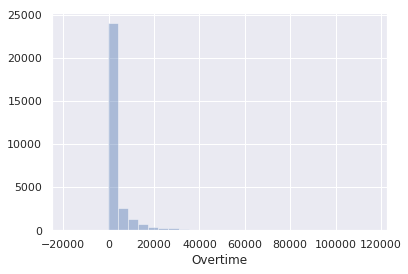

In [0]:
#let's look at the distribution of the overtime earned for nursing jobs
ax = sns.distplot(nursing['Overtime'], bins = 30, kde = False)

In [0]:
#let's see if I can learn more about overall trend in overtime by looking at statistics for each year, starting with 2013
y2013['Overtime'].describe()

count     4234.000000
mean      1527.481176
std       4800.691101
min          0.000000
25%          0.000000
50%          0.000000
75%        228.720000
max      53864.340000
Name: Overtime, dtype: float64

Looks like our average earned overtime in 2013 was around 1527, with over 75% earning closer to 228 dollars, while our maximum value is at 53864, with 50% of employees earning zero dollars in overtime.

In [0]:
y2014['Overtime'].describe()

count     4211.000000
mean      1489.067174
std       4674.572518
min     -12308.660000
25%          0.000000
50%          0.000000
75%        478.360000
max      55976.970000
Name: Overtime, dtype: float64


In 2014 our average dollar amount in overtime earned is 1489, but we also have some negative values that are skewing the results -- it doesn't make sense to have employees earn negative overtime. Year 2014 once again shows that the majority of employees have 0 overtime, additionally there appear to be some negative values as well.

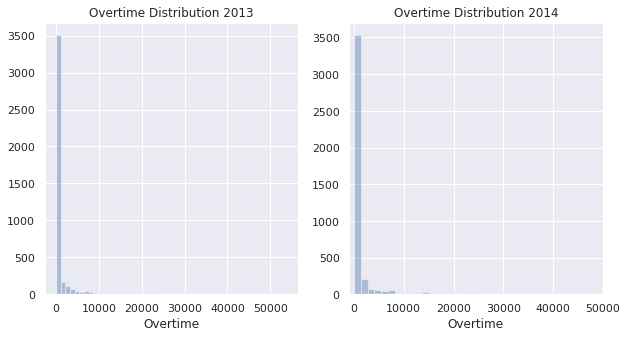

In [0]:
#start a histogram to illustrate distribution of overtime in 2013
plt.figure(figsize = (10, 5))

plt.subplot (1,2,1)

ax = sns.distplot(y2013['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2013')

#start a histogram to illustrate distribution of overtime in 2014
plt.subplot (1,2,2)

bx = sns.distplot(y2014['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2014')
plt.xlim(-1000, 50000)
plt.show;

We see right-skewed distributions, also known as positively skewed distribution, meaning large number of data values occurs on the left side with the range boundary on the left-hand side of the histogram, in our case at 0 dollars. This would make sense for dollar amounts of overtime earned - looks like we have high frequency of zero values for overtime, indicating that majority of nursing employees do not work overtime and very few earned over 10,000 dollars.

In [0]:
y2015['Overtime'].describe()

count     4301.000000
mean      1880.069635
std       5568.671616
min          0.000000
25%          0.000000
50%          0.000000
75%        854.120000
max      75901.840000
Name: Overtime, dtype: float64

Year 2015 shows that average overtime earned was 1880 dollars, with no negative values.

In [0]:
y2016['Overtime'].describe()

count     4237.000000
mean      1952.688051
std       4964.198709
min       -213.500000
25%          0.000000
50%          0.000000
75%       1316.140000
max      49546.890000
Name: Overtime, dtype: float64

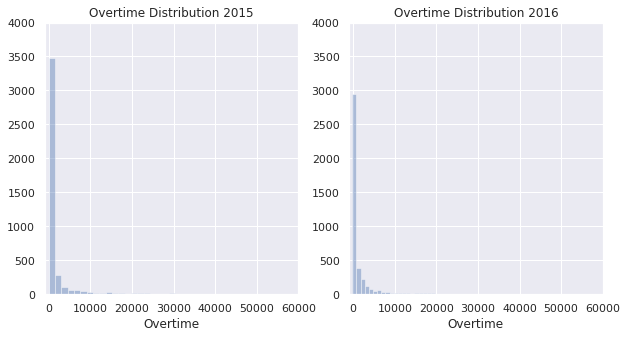

In [0]:
#start a histogram to illustrate distribution of overtime in 2015 and 2016
plt.figure(figsize = (10, 5))

plt.subplot (1,2,1)

ax = sns.distplot(y2015['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2015')
plt.xlim(-1000, 60000)
plt.ylim(0, 4000)

#start a histogram to illustrate distribution of overtime in 2016
plt.subplot (1,2,2)

bx = sns.distplot(y2016['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2016')
plt.xlim(-1000, 60000)
plt.ylim(0, 4000)
plt.show;

It looks like in 2016 there is a noticeable change in decreased frequency of nursing employees earning zero dollars in overtime and a slight increase of frequency for under 10,000 dollars earned in overtime.

In [0]:
y2017['Overtime'].describe()

count     4443.000000
mean      2559.755318
std       6172.218471
min       -611.750000
25%          0.000000
50%          0.000000
75%       1806.670000
max      76791.870000
Name: Overtime, dtype: float64

In [0]:
y2018['Overtime'].describe()

count      4422.00000
mean       4870.23180
std        8286.56928
min           0.00000
25%           0.00000
50%        1478.77000
75%        6887.15250
max      102347.99000
Name: Overtime, dtype: float64

In [0]:
y2019['Overtime'].describe()

count      4522.000000
mean       5037.830102
std        8590.724923
min      -18458.150000
25%           0.000000
50%        1458.480000
75%        6962.330000
max      115780.470000
Name: Overtime, dtype: float64

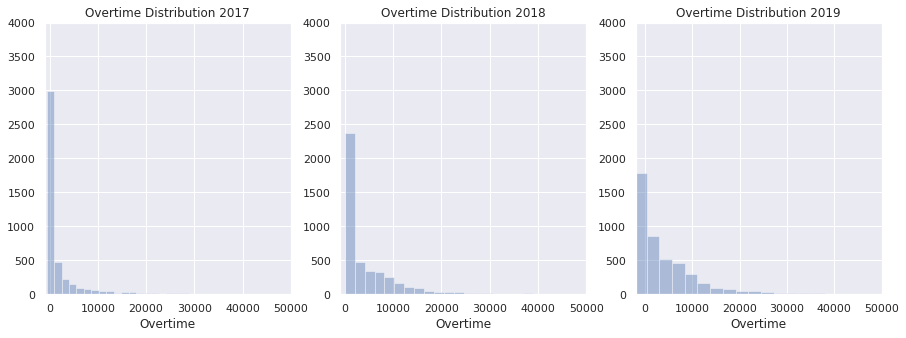

In [0]:
#start a histogram to illustrate distribution of overtime in 2017, 2018, and 2019
plt.figure(figsize = (15, 5))
plt.subplot (1,3,1)

ax = sns.distplot(y2017['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2017')
plt.xlim(-1000, 50000)
plt.ylim(0, 4000)

#start a histogram to illustrate distribution of overtime in 2018
plt.subplot (1,3,2)

bx = sns.distplot(y2018['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2018')
plt.xlim(-1000, 50000)
plt.ylim(0, 4000)

#start a histogram to illustrate distribution of overtime in 2019
plt.subplot (1,3,3)

cx = sns.distplot(y2019['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2019')
plt.xlim(-2000, 50000)
plt.ylim(0, 4000)

plt.show;


Looking at the histogram of overtime earned distribution for 2017 we can observe a continued trend in decreasing frequency of nursing employees earning zero overtime and increased frequency for less than 10,000 dollars in overtime. It appears that the trend of decrease in employees earning zero overtime continues in 2018 with increased frequency of some nursing employees earning over 10,000 dollars in overtime in 2018.

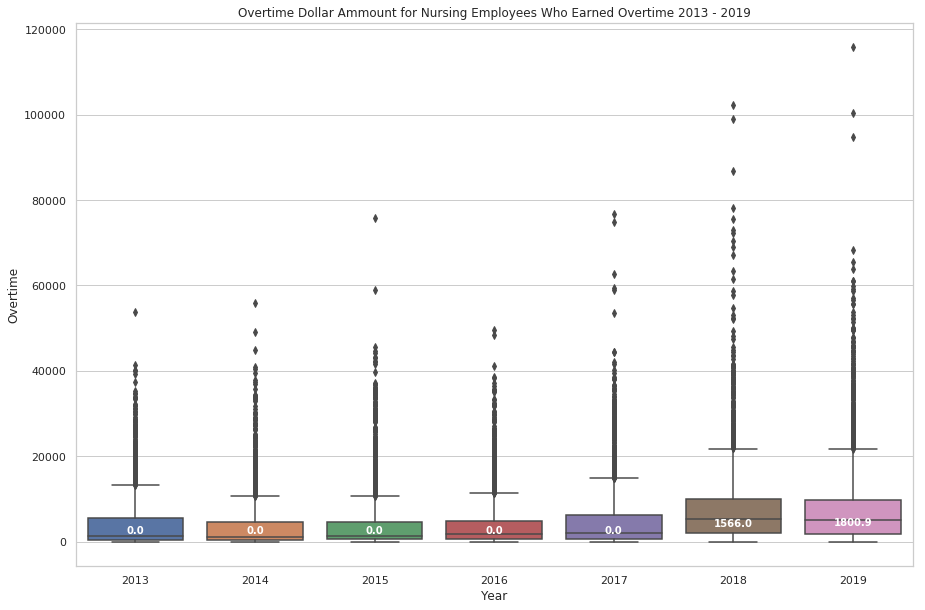

In [0]:
#since some of our data has negative values for overtime and majority has zero, 
#let's see what is the distribution for overtime for employees who earned overtime

no_zero_overtime = ( nursing['Overtime'] > 0)
only_overtime_df = nursing.iloc[no_zero_overtime.values]

plt.rcParams["figure.figsize"] = (15, 10)
plt.title('Overtime Dollar Ammount for Nursing Employees Who Earned Overtime 2013 - 2019')
ax = sns.boxplot( x = 'Year', y = 'Overtime', data = only_overtime_df)

medians = nursing.groupby(['Year'])['Overtime'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 2000, median_labels[tick], 
            horizontalalignment='center', size='small', color='w', weight='bold')

plt.show;


In [0]:
# who earned the most overtime from 2013 to 2019?

nursing.nlargest(10, columns = 'Overtime')

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
103314,Fiscal,2019,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2312,Licensed Vocational Nurse,8496637,72716.11,115780.47,4851.10,193347.68,14790.13,12832.98,13596.95,41220.06,234567.74
267060,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8507669,95706.00,102347.99,18619.01,216673.00,0.00,0.00,3694.74,3694.74,220367.74
85483,Fiscal,2019,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2312,Licensed Vocational Nurse,8586394,75036.50,100380.42,4597.19,180014.11,15185.05,12753.65,8148.12,36086.82,216100.93
245089,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2312,Licensed Vocational Nurse,8586394,77714.00,98898.22,5906.41,182518.63,16058.43,13588.32,12787.19,42433.94,224952.57
124859,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8591543,143998.51,94726.32,14539.84,253264.67,0.00,0.00,11055.45,11055.45,264320.12
239826,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8591543,143392.53,86828.14,13645.25,243865.92,0.00,0.00,14513.95,14513.95,258379.87
286606,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2302,Nursing Assistant,8510070,73405.20,78206.57,6142.23,157754.00,15264.77,13808.84,12016.59,41090.20,198844.20
467207,Fiscal,2017,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,15631,105745.73,76791.87,25580.94,208118.54,0.00,7802.45,3565.52,11367.97,219486.51
647223,Fiscal,2015,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,20756,140373.17,75901.84,8694.80,224969.81,0.00,10701.45,15953.56,26655.01,251624.82
268749,Fiscal,2018,4,Community Health,DPH,NaN,250.0,"SEIU, Local 1021, Misc",2300,Nursing,2312,Licensed Vocational Nurse,8574793,59335.02,75484.95,816.02,135635.99,11540.62,10914.37,10702.34,33157.33,168793.32


##Nursing Salaries, Fiscal Years 2013-2019

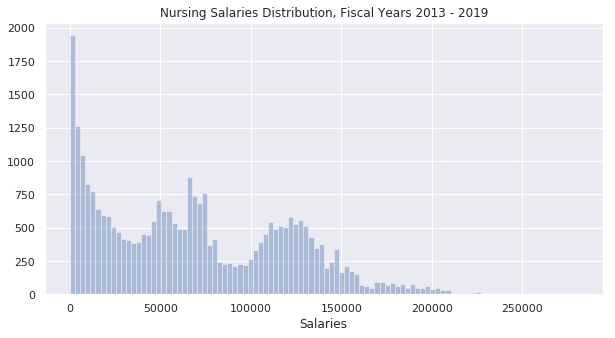

In [0]:
#let's see salaries distribution for all the nursing jobs for fiscal years 2013-2019
plt.figure(figsize = (10,5))
ax = sns.distplot(nursing['Salaries'], bins = 100, kde = False)
plt.title('Nursing Salaries Distribution, Fiscal Years 2013 - 2019')
plt.show;

Here we have right skewed multimodal distribution (multiple peaks) with mostly positive values, there are some negatives present as well. 

Since we have multiple nursing jobs with various salary ranges included in the data, the different peaks present can represent different classes of nursing jobs (like Registered Nurse vs Nursing Assistant). For the purpose of this analysis I am more interested in the overall salary trends from 2013 to 2018 for nursing type jobs and will not separate the data by different classes.

In [0]:
#Let's sort our rows by salaries, to get a general overview of how nursing employees are reimbursed

nursing_sorted_df = nursing.sort_values(by= 'Salaries', ascending=True)

#select the first 30 rows
nursing_sorted_df.head(20)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
742622,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,54929,5.10,0.00,24430.50,24435.60,1.05,0.00,1869.34,1870.39,26305.99
747808,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,54128,6.00,0.00,8410.99,8416.99,1.24,0.00,643.91,645.15,9062.14
716500,Fiscal,2014,4,Community Health,DPH,DPH Public Health,858.0,"Teamsters - Supervising Nurses, Local 856",2300,Nursing,2322,Nurse Manager,54337,7.50,0.00,19600.71,19608.21,1.36,0.00,1500.05,1501.41,21109.62
240376,Fiscal,2018,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,2328,Nurse Practitioner,8578359,10.55,0.00,0.00,10.55,1.87,0.00,0.83,2.70,13.25
724812,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2320,Registered Nurse,37300,15.00,0.00,12470.52,12485.52,3.09,0.00,955.18,958.27,13443.79
815430,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,26146,18.24,0.00,3.19,21.43,975.63,0.00,-0.01,975.62,997.05
570391,Fiscal,2016,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,23086,18.61,0.00,1.86,20.47,0.00,1.56,1.57,3.13,23.60
804372,Fiscal,2013,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,17139,18.81,0.00,3.76,22.57,0.00,0.00,349.05,349.05,371.62
725017,Fiscal,2014,4,Community Health,DPH,DPH Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,P103,Special Nurse,37936,18.81,0.00,1.88,20.69,0.00,0.00,0.00,0.00,20.69
86679,Fiscal,2019,4,Community Health,DPH,NaN,791.0,"SEIU, Local 1021, RN",2300,Nursing,P103,Special Nurse,8586954,19.77,1074.49,1.98,1096.24,0.00,0.00,86.78,86.78,1183.02


In [0]:
nursing[['Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement', 'Total Benefits', 'Total Compensation']].describe()


,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Total Benefits,Total Compensation
count,29889.000000,29889.000000,29889.000000,29889.00000,29889.000000,29889.000000,29889.000000
mean,68945.485435,2834.580461,6574.927263,78354.99316,11806.734535,23972.263387,102327.256547
std,51547.523276,6576.915481,8440.646126,57933.59886,11822.387456,19441.821922,75706.583123
min,5.100000,-18458.150000,-891.190000,10.55000,-28723.190000,-19814.440000,-3320.450000
25%,21376.840000,0.000000,569.330000,23960.83000,0.000000,3944.600000,29663.400000
50%,63207.320000,0.000000,3344.180000,72186.30000,10735.690000,25153.730000,97497.720000
75%,112478.560000,2302.200000,9205.610000,127016.12000,22058.030000,41105.130000,166657.290000
max,280545.000000,115780.470000,105311.950000,304876.85000,64849.970000,88431.580000,384127.350000


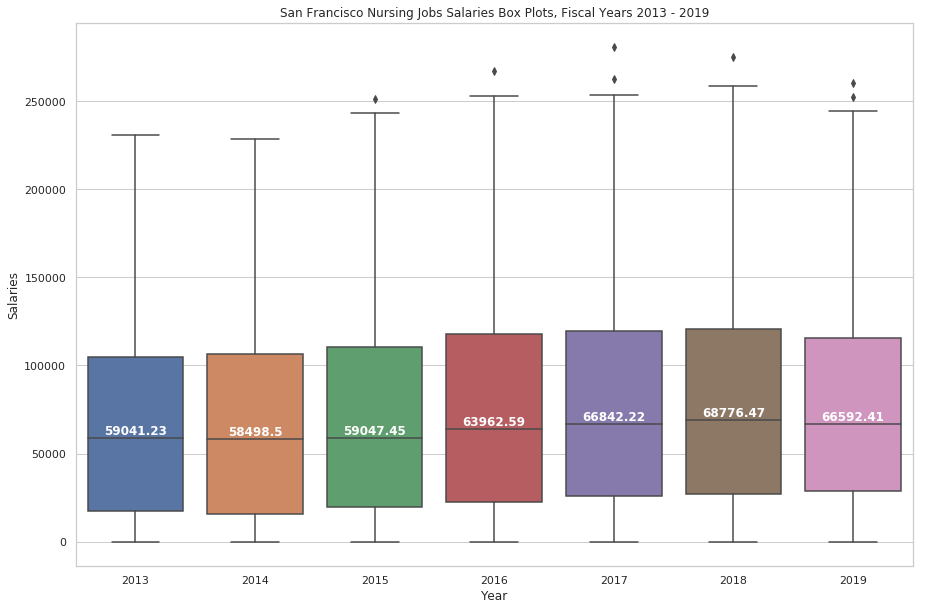

In [0]:
#since we have eliminated negative salary values earlier, let's compare salaries that are greater than zero dollars

plt.rcParams["figure.figsize"] = (15, 10)
ax = sns.boxplot( x = 'Year', y = 'Salaries', data = nursing)
sns.set_style("whitegrid")

medians = nursing.groupby(['Year'])['Salaries'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 2000, median_labels[tick], 
            horizontalalignment='center', size='medium', color='w', weight='bold')

plt.title('San Francisco Nursing Jobs Salaries Box Plots, Fiscal Years 2013 - 2019')
plt.show;

In [0]:
nursing[['Salaries', 'Overtime', 'Total Salary', 'Other Salaries', 'Retirement', 'Total Benefits', 'Total Compensation']].corr()

,Salaries,Overtime,Total Salary,Other Salaries,Retirement,Total Benefits,Total Compensation
Salaries,1.000000,0.135666,0.985636,0.552285,0.848874,0.883126,0.981038
Overtime,0.135666,1.000000,0.250081,0.108751,0.127822,0.219685,0.247788
Total Salary,0.985636,0.250081,1.000000,0.649447,0.846770,0.886593,0.992920
Other Salaries,0.552285,0.108751,0.649447,1.000000,0.528211,0.520777,0.630720
Retirement,0.848874,0.127822,0.846770,0.528211,1.000000,0.969018,0.896830
Total Benefits,0.883126,0.219685,0.886593,0.520777,0.969018,1.000000,0.935260
Total Compensation,0.981038,0.247788,0.992920,0.630720,0.896830,0.935260,1.000000


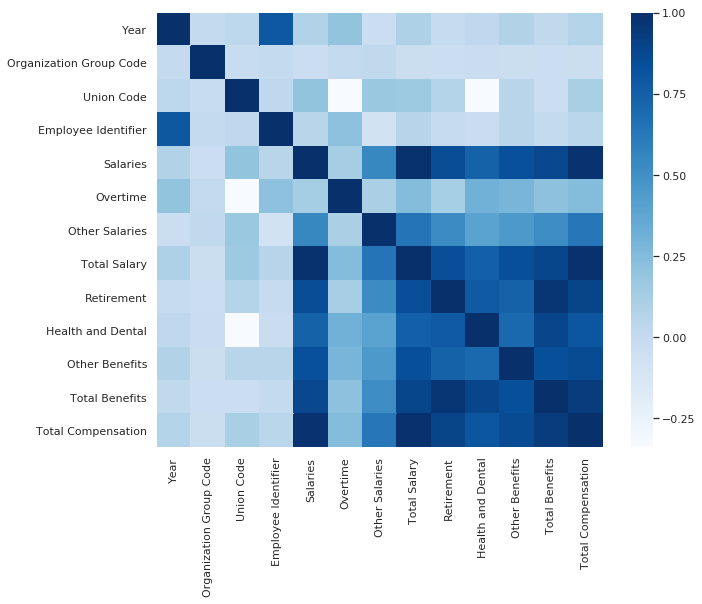

In [0]:
#let's visualize various levels of correlation via a heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(nursing.corr(), cmap = 'Blues')
plt.show;

Compared to other categories, like "Other Salaries", "Total Salary" and benefits, "Overtime" category has the least strong correlation to "Salaries", this shows us that salary amount does not directly influence overtime. For example an increase in salary would not necessarily mean more overtime is earned.

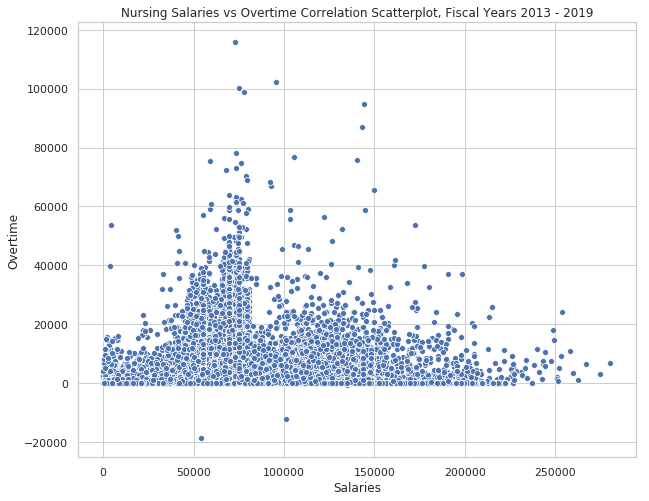

In [0]:
#let's do a scatterplot to see if we can observe any correlation between salaries and overtime

plt.figure(figsize = (10, 8))
sns.scatterplot( x = 'Salaries' , y = 'Overtime', data = nursing)
plt.title('Nursing Salaries vs Overtime Correlation Scatterplot, Fiscal Years 2013 - 2019')
plt.show;

Once again, there is no linear correlation between salaries and overtime earned, and highest dollar amounts in overtime fall in less than 100,000 salary range.

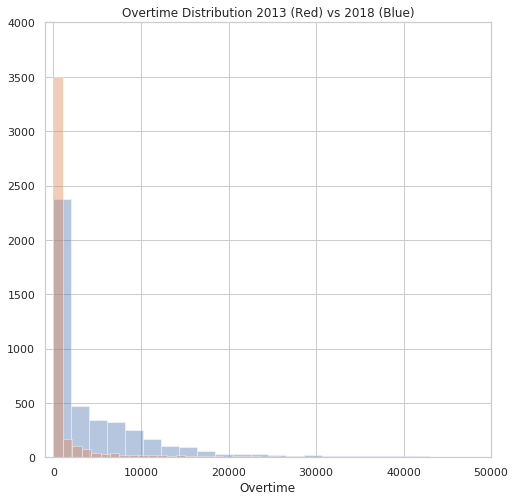

In [0]:
#start a histogram to illustrate distribution of overtime in 2013 overlayed with 2018

plt.figure(figsize = (8, 8))

ax = sns.distplot(y2018['Overtime'], bins = 50, kde = False)

bx = sns.distplot(y2013['Overtime'], bins = 50, kde = False)

plt.title('Overtime Distribution 2013 (Red) vs 2018 (Blue)')
plt.xlim(-1000, 50000)
plt.ylim(0, 4000)

plt.show;

In order to verify if there is statistically significant difference in overtime earned over a five year period, I will focus on comparing 2013 and 2013 data for independent samples t-test further in my analysis.

#Independent Samples T-Test

##Null hypothesis 1
There is no statistically significant difference in the mean salary for nurses employed by the city of San Francisco in 2013 vs 2018.

##Null hypothesis 2
There is no statistically significant difference in the mean overtime earnings for nurses employed by the city of San Francisco in 2013 vs 2018.

In [0]:
#let's run some basic statistics on 2013 numerical nursing jobs data without negative or zero values for salaries

y2013[['Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement', 'Total Benefits', 'Total Compensation']].describe()


,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Total Benefits,Total Compensation
count,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000
mean,62240.863713,1527.481176,6494.494490,70262.839379,10701.575328,22135.148977,92397.988356
std,48372.215637,4800.691101,8145.487268,53911.035636,10899.514277,17901.987751,70561.004571
min,-1861.500000,0.000000,-598.820000,-1923.540000,-21302.020000,-14011.930000,-1956.230000
25%,16096.837500,0.000000,571.480000,18483.537500,178.252500,4393.430000,23773.400000
50%,58836.570000,0.000000,3408.055000,65699.640000,9410.315000,21582.570000,88744.215000
75%,104499.012500,228.720000,9281.767500,116672.212500,20384.472500,36833.760000,152754.505000
max,231043.580000,53864.340000,72262.980000,249474.680000,49567.770000,74015.200000,323489.880000


In [0]:
#what else do we know about 2013 data?

y2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4234 entries, 793410 to 832878
Data columns (total 22 columns):
Year Type                  4234 non-null object
Year                       4234 non-null int64
Organization Group Code    4234 non-null int64
Organization Group         4234 non-null object
Department Code            4234 non-null object
Department                 4234 non-null object
Union Code                 4234 non-null float64
Union                      4234 non-null object
Job Family Code            4234 non-null object
Job Family                 4234 non-null object
Job Code                   4234 non-null object
Job                        4234 non-null object
Employee Identifier        4234 non-null int64
Salaries                   4234 non-null float64
Overtime                   4234 non-null float64
Other Salaries             4234 non-null float64
Total Salary               4234 non-null float64
Retirement                 4234 non-null float64
Health and Dental  

In [0]:
#let's do basic statistics analisys on the salary information for the fiscal year 2018

y2018[['Salaries', 'Overtime', 'Other Salaries', 'Total Salary', 'Retirement', 'Total Benefits', 'Total Compensation']].describe()


,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Total Benefits,Total Compensation
count,4422.000000,4422.00000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000
mean,73907.896906,4870.23180,5637.590900,84415.719607,11930.831782,24257.843478,108673.563085
std,53727.128139,8286.56928,7553.473731,60449.975519,12147.297661,21107.146368,79312.693954
min,0.000000,0.00000,-69.310000,0.000000,-27490.570000,-17445.820000,13.250000
25%,25444.655000,0.00000,490.257500,28489.650000,0.000000,2090.130000,32673.680000
50%,67419.135000,1478.77000,2609.950000,78271.785000,11271.000000,27080.085000,104104.665000
75%,120302.865000,6887.15250,7284.075000,135586.555000,23262.732500,44454.612500,177268.255000
max,274825.020000,102347.99000,74509.730000,301015.830000,54958.970000,82170.050000,382546.870000


In [0]:
#what else do we know about 2018 data?
y2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4422 entries, 223583 to 298145
Data columns (total 22 columns):
Year Type                  4422 non-null object
Year                       4422 non-null int64
Organization Group Code    4422 non-null int64
Organization Group         4422 non-null object
Department Code            4422 non-null object
Department                 0 non-null object
Union Code                 4422 non-null float64
Union                      4422 non-null object
Job Family Code            4422 non-null object
Job Family                 4422 non-null object
Job Code                   4422 non-null object
Job                        4422 non-null object
Employee Identifier        4422 non-null int64
Salaries                   4422 non-null float64
Overtime                   4422 non-null float64
Other Salaries             4422 non-null float64
Total Salary               4422 non-null float64
Retirement                 4422 non-null float64
Health and Dental     

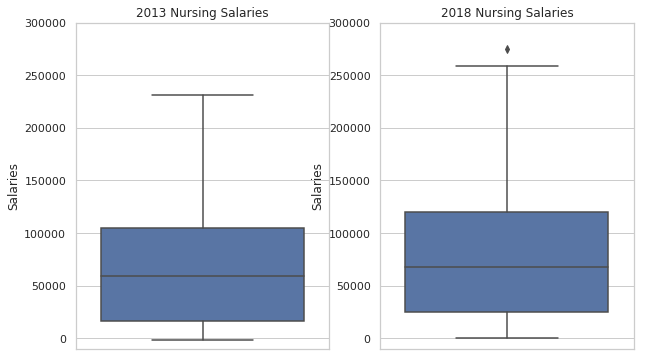

In [0]:
#let's review how 2013 and 2018 fiscal year nursing salaries compare

plt.rcParams["figure.figsize"] = (10, 6)
plt.subplot(1,2,1)
sns.boxplot( y = 'Salaries', data = y2013)
plt.title('2013 Nursing Salaries')
plt.ylim(-10000,300000)


plt.subplot(1,2,2)
plt.title('2018 Nursing Salaries')
plt.ylim(-10000,300000)
sns.boxplot( y = 'Salaries', data = y2018)
plt.show;

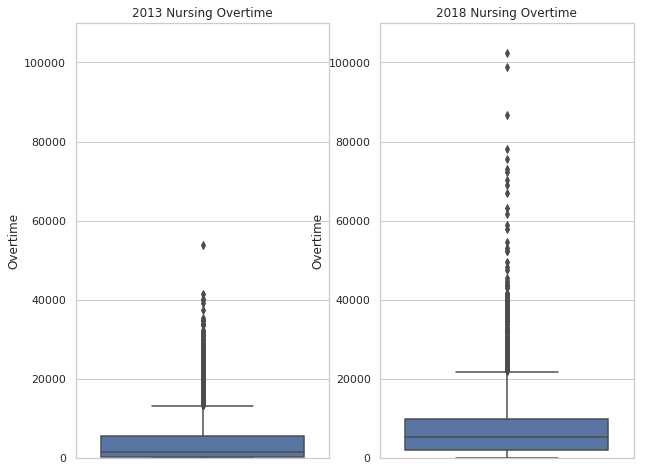

In [0]:
#let's see how overtime earned in dollars compares between 2013 and 2018 fiscal years

no_zero_overtime_2013 = ( y2013['Overtime'] > 0)
y2013_overtime = y2013.iloc[no_zero_overtime_2013.values]

no_zero_overtime_2018 = ( y2018['Overtime'] > 0)
y2018_overtime = y2018.iloc[no_zero_overtime_2018.values]

plt.rcParams["figure.figsize"] = (10, 8)
plt.subplot(1,2,1)
sns.boxplot( y = 'Overtime', data = y2013_overtime)
plt.title('2013 Nursing Overtime')
plt.ylim(0,110000)


plt.subplot(1,2,2)
plt.title('2018 Nursing Overtime')
plt.ylim(0,110000)
sns.boxplot( y = 'Overtime', data = y2018_overtime)
plt.show;

Looks like we have over 4000 rows of data for both fiscal year 2013 and 2018, let's conduct our independent sample t-test to test our hypotheses.

In [0]:
#hypothesis 1 independent samples t-test

stats.ttest_ind(y2018['Salaries'], y2013['Salaries'])

Ttest_indResult(statistic=10.60240112214114, pvalue=4.197606558292816e-26)

##Testing Hypothesis 1, Results

Reject the null hypothesis that there is no statistical significant difference between mean salaries for nursing staff in fiscal year 2013 and 2018. 

Our p value is very small and the difference between our two means is 10.6 standard deviations, indicating that our difference between the salary means is statistically significant and is unlikely to be due to random chance.

In [0]:
#hypothesis 2 independent sample t-test

stats.ttest_ind(y2018['Overtime'], y2013['Overtime'])

Ttest_indResult(statistic=22.834617091753582, pvalue=4.076162424460913e-112)

##Testing Hypothesis 2, Results

Reject the null hypothesis that there is no statistically significant difference between mean overtime earned by nursing staff in fiscal year 2013 and 2018. 


Our p very is extremely small, there is a difference of 22.8 standard deviations between the two means.

#Conclusion

It appears that there is a significant difference in mean salaries for nursing staff between 2013 and 2018 fiscal years. Further study would need to be done in order to determine if this increase is significant over the 5 year period, once inflation and increased cost of living is taken into account. At this time, the city of San Francisco would need to plan the budget for the increasing nursing salaries, should the trend we observed in this data continue into 2020.

Following analysis using independent samples t- test, there is a statistically significant difference between means for overtime earned between 2013 and 2018 fiscal years. As there is no apparent correlation between salary and the overtime dollar amount earned, the observed increase salary does not necessarily cause an increase in overtime.

Looking at the data, it appears that the difference between 2013 and 2018 fiscal years' overtime earned is statistically significant, as our independent samples t-test showed 22.8 standard deviations difference between the two means. That is almost twice that of the difference in means for salaries that came out to 10.6 standard deviations. Both tests had extremely small p value, showing difference is statistically significant in both cases.

This could be a warning sign for the city and current as well as future nursing staff, as increasing overtime could be a signal that more nursing employees needs to be hired based on increasing demand posed by a growing population of aging residents. Having employees work long overtime hours on top of already demanding and fairly stressful full time job can lead to lack of quality of service provided to patients and other potential complications like malpractice.